In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras, convert_to_tensor
from keras.utils import load_img, img_to_array, save_img
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.optimizers import SGD

In [2]:
content_image_path = '/content/drive/MyDrive/Data/content/content03.jpg'
style_image_path = '/content/drive/MyDrive/Data/style/style03.jpg'
result_prefix = 'generated_image'

In [3]:
VAR_WGT = 1e-6
STYLE_WGT = 1e-6
CONTENT_WGT = 2.5e-8

W, H = load_img(content_image_path).size

IMG_ROW = 400
IMG_COL = int(W * IMG_ROW / H)

In [4]:
def load_image(image):
  
  img = load_img(image, target_size = (IMG_ROW, IMG_COL))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)

  return img

In [5]:
def imshow(img, title = None):
  
  out = np.squeeze(img, axis = 0)
  out = out.astype('uint8')
  plt.imshow(out)
  
  if title is not None:
    plt.title(title)
  
  plt.imshow(out)

In [6]:
def preprocess_image(image):
  
  img = load_image(image)
  img = preprocess_input(img)
  
  return convert_to_tensor(img) 

In [7]:
def deprocess_image(tensor):
  
  tensor = tensor.reshape((IMG_ROW, IMG_COL, 3))
  tensor[:, :, 0] += 103.939
  tensor[:, :, 1] += 116.779
  tensor[:, :, 2] += 123.68
  
  tensor = tensor[:, :, ::-1]
  tensor = np.clip(tensor, 0, 255).astype("uint8")
  
  return tensor

In [8]:
def gram_matrix(x):
	
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    
    return gram
    
def style_loss(style, combination):
    
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = IMG_ROW * IMG_COL
    
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
    
def content_loss(base, combination):
    
    return tf.reduce_sum(tf.square(combination - base))
    
def total_variation_loss(x):
    
    a = tf.square(x[:, : IMG_ROW - 1, : IMG_COL - 1, :] - x[:, 1:, : IMG_COL - 1, :])
    b = tf.square(x[:, : IMG_ROW - 1, : IMG_COL - 1, :] - x[:, : IMG_ROW - 1, 1:, :])
    
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [9]:
model = VGG19(weights="imagenet", include_top = False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"

In [10]:
def compute_loss(generated_image, content_image, style_image):
    
    input_tensor = tf.concat(
        [content_image, style_image, generated_image], axis=0
    )
    
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + CONTENT_WGT * content_loss(
        base_image_features, combination_features
    )
    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (STYLE_WGT / len(style_layer_names)) * sl

    
    loss += VAR_WGT * total_variation_loss(generated_image)
    
    return loss

In [11]:
@tf.function
def compute_loss_and_grads(generated_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, content_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads
    
optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)
generated_image = tf.Variable(preprocess_image(content_image_path))

steps = 2000
for i in range(1, steps + 1):
    loss, grads = compute_loss_and_grads(
        generated_image, content_image, style_image
    )
    optimizer.apply_gradients([(grads, generated_image)])
    if i % 500 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(generated_image.numpy())
        fname = result_prefix + "_at_step_%d.png" % i
        save_img(fname, img)

Iteration 500: loss=2975.87
Iteration 1000: loss=2736.08
Iteration 1500: loss=2634.44
Iteration 2000: loss=2576.35


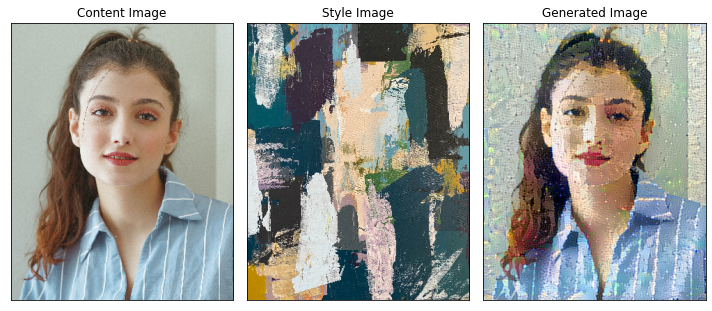

In [12]:
gip = '/content/generated_image_at_step_2000.png'

plt.figure(figsize=(10,5))

content = load_image(content_image_path)
style = load_image(style_image_path)
generated = load_image(gip)

plt.subplot(1, 3, 1)
imshow(content, 'Content Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
imshow(style, 'Style Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
imshow(generated, 'Generated Image')
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.show()